In [2]:
# Import the libraries
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline

warnings.simplefilter(action = "ignore", category = FutureWarning)

# Load the clean version of the dataset
# Assign to a dataframe
# Perform feature selection:
df_rainfall = pd.read_csv("weather_clean.csv")
df_rainfall.drop(columns = ["DewPointHighF", "DewPointLowF"], inplace = True)

# Remove outliers from the data;
#'VisibilityHighMiles' column:
low, high = df_rainfall["VisibilityHighMiles"].quantile([0.01, 1])
mask_visibilityH = df_rainfall["VisibilityHighMiles"].between(low, high)
#'SeaLevelPressureAvgInches' column:
low, high = df_rainfall["SeaLevelPressureAvgInches"].quantile([0.25, 1])
mask_seaLevel = df_rainfall["SeaLevelPressureAvgInches"].between(low, high)

# Transform the dataframe:
df_rainfall = df_rainfall[mask_visibilityH & mask_seaLevel]

In [ ]:
# The independent variables:
input_ds = df_rainfall.drop(columns = ["PrecipitationSumInches", "Unnamed: 0"])
# The dependent variable:
output_ds = df_rainfall["PrecipitationSumInches"]
print(input_ds.shape, output_ds.shape)
input_train, input_test, output_train, output_test = train_test_split(input_ds, output_ds, test_size = 0.2, random_state = 42)

print("input train: ", input_train.shape)
print("\ninput test: ", input_test.shape)
print("\noutput train: ", output_train.shape)
print("\noutput test: ", output_test.shape)

(1008, 14) (1008,)
input train:  (806, 14)

input test:  (202, 14)

output train:  (806,)

output test:  (202,)


In [ ]:
# Standardize the training and test set:
scaler = StandardScaler()
input_train_scaled = scaler.fit_transform(input_train)
input_test_scaled = scaler.transform(input_test)

# Reshape the input data to match the expected input shape for the RNN
seq_length = input_train.shape[1]  # Assuming each row is a time sequence
num_features = 1
input_train_reshaped = np.reshape(input_train_scaled, (input_train.shape[0], seq_length, 1))
input_test_reshaped = np.reshape(input_test_scaled, (input_test.shape[0], seq_length, 1))


Epoch 1/10
21/21 - 2s - loss: 0.1042 - val_loss: 0.0514 - 2s/epoch - 79ms/step
Epoch 2/10
21/21 - 0s - loss: 0.0776 - val_loss: 0.0437 - 114ms/epoch - 5ms/step
Epoch 3/10
21/21 - 0s - loss: 0.0667 - val_loss: 0.0480 - 112ms/epoch - 5ms/step
Epoch 4/10
21/21 - 0s - loss: 0.0604 - val_loss: 0.0440 - 107ms/epoch - 5ms/step
Epoch 5/10
21/21 - 0s - loss: 0.0571 - val_loss: 0.0493 - 112ms/epoch - 5ms/step
Epoch 6/10
21/21 - 0s - loss: 0.0554 - val_loss: 0.0501 - 113ms/epoch - 5ms/step
Epoch 7/10
21/21 - 0s - loss: 0.0526 - val_loss: 0.0459 - 117ms/epoch - 6ms/step
Epoch 8/10
21/21 - 0s - loss: 0.0533 - val_loss: 0.0486 - 114ms/epoch - 5ms/step
Epoch 9/10
21/21 - 0s - loss: 0.0499 - val_loss: 0.0513 - 115ms/epoch - 5ms/step
Epoch 10/10
21/21 - 0s - loss: 0.0478 - val_loss: 0.0534 - 114ms/epoch - 5ms/step
7/7 [==============================] - 0s 2ms/step - loss: 0.0666

 Test Loss: 0.06664767861366272 

7/7 [==============================] - 0s 2ms/step


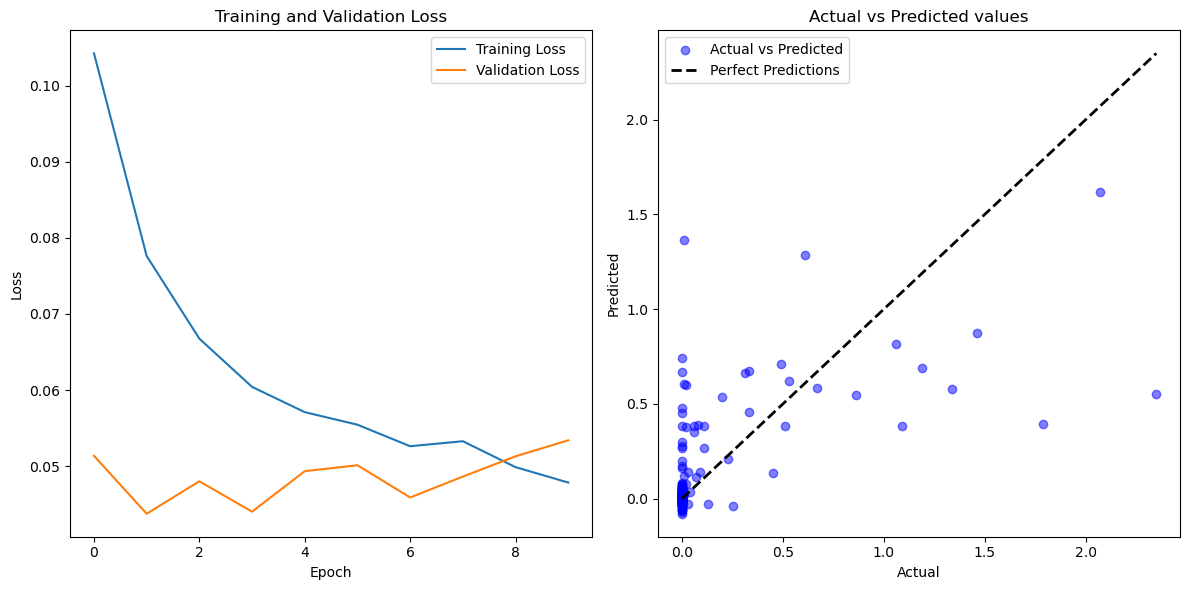

7/7 [==============================] - 0s 2ms/step

      Actual  Predicted
0      0.00  -0.032231
1      0.00   0.011744
2      0.00  -0.023536
3      0.00   0.027789
4      0.13  -0.029027
..      ...        ...
197    0.00  -0.007953
198    0.00  -0.000378
199    0.00  -0.034296
200    0.09   0.138858
201    0.00   0.744018

[202 rows x 2 columns] 


 Root Mean Squared Error (RMSE): 0.2581621213603857 


 Correlation Coefficient: 0.639162841159669 



In [ ]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(input_train_reshaped, output_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss = model.evaluate(input_test_reshaped, output_test)
print('\n',f'Test Loss: {loss}','\n')

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting actual vs predicted values
plt.subplot(1, 2, 2)
predictions = model.predict(input_test_reshaped)
plt.scatter(output_test, predictions, alpha=0.5, color='blue', label='Actual vs Predicted')
plt.plot([output_test.min(), output_test.max()], [output_test.min(), output_test.max()], '--k', linewidth=2, label='Perfect Predictions')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.tight_layout()
plt.show()


# Make predictions
predictions = model.predict(input_test_reshaped)
result_df = pd.DataFrame({'Actual': output_test.values, 'Predicted': predictions.flatten()})
print('\n',result_df,'\n')

# Calculate Mean Squared Error
mse = mean_squared_error(output_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('\n',f'Root Mean Squared Error (RMSE): {rmse}','\n')

# Calculate correlation coefficient
corr_coef, _ = pearsonr(output_test, predictions.flatten())
print('\n',f'Correlation Coefficient: {corr_coef}','\n')

Epoch 1/10
21/21 - 2s - loss: 0.0960 - val_loss: 0.0501 - 2s/epoch - 103ms/step
Epoch 2/10
21/21 - 0s - loss: 0.0929 - val_loss: 0.0468 - 191ms/epoch - 9ms/step
Epoch 3/10
21/21 - 0s - loss: 0.0896 - val_loss: 0.0433 - 192ms/epoch - 9ms/step
Epoch 4/10
21/21 - 0s - loss: 0.0842 - val_loss: 0.0416 - 180ms/epoch - 9ms/step
Epoch 5/10
21/21 - 0s - loss: 0.0769 - val_loss: 0.0331 - 198ms/epoch - 9ms/step
Epoch 6/10
21/21 - 0s - loss: 0.0718 - val_loss: 0.0308 - 194ms/epoch - 9ms/step
Epoch 7/10
21/21 - 0s - loss: 0.0660 - val_loss: 0.0285 - 202ms/epoch - 10ms/step
Epoch 8/10
21/21 - 0s - loss: 0.0657 - val_loss: 0.0280 - 202ms/epoch - 10ms/step
Epoch 9/10
21/21 - 0s - loss: 0.0604 - val_loss: 0.0292 - 246ms/epoch - 12ms/step
Epoch 10/10
21/21 - 0s - loss: 0.0579 - val_loss: 0.0301 - 198ms/epoch - 9ms/step
7/7 [==============================] - 0s 5ms/step - loss: 0.0626

 Test Loss: 0.06262028962373734 



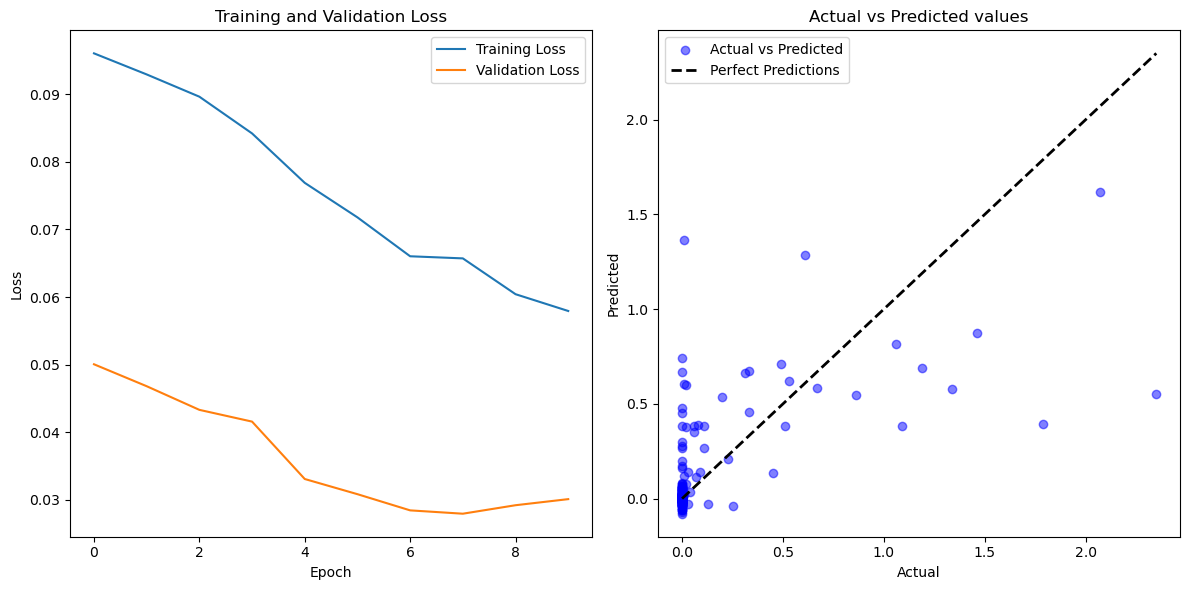


 Root Mean Squared Error (RMSE): 0.2581621213603857 


 Correlation Coefficient: 0.639162841159669 



In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(input_train_reshaped, output_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss = model.evaluate(input_test_reshaped, output_test)
print('\n',f'Test Loss: {loss}','\n')

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting actual vs predicted values
plt.subplot(1, 2, 2)
plt.scatter(output_test, predictions, alpha=0.5, color='blue', label='Actual vs Predicted')
plt.plot([output_test.min(), output_test.max()], [output_test.min(), output_test.max()], '--k', linewidth=2, label='Perfect Predictions')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(output_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('\n',f'Root Mean Squared Error (RMSE): {rmse}','\n')

# Calculate correlation coefficient
corr_coef, _ = pearsonr(output_test, predictions.flatten())
print('\n',f'Correlation Coefficient: {corr_coef}','\n')

In [ ]:
# Initialize the XGBoost Regressor(Gradient Boosting)
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Train the model
model.fit(input_train, output_train)

# Make predictions on the test set
predictions = model.predict(input_test)

# Evaluate the model
mse = mean_squared_error(output_test, predictions)
rmse = np.sqrt(mse)
print('\n',f'Root Mean Squared Error (RMSE): {rmse}','\n')

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(output_test, predictions)
plt.title('Actual vs Predicted values (XGBoost)')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plotting the diagonal line (perfect predictions)
plt.plot([output_test.min(), output_test.max()], [output_test.min(), output_test.max()], '--k', linewidth=2)
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', xlabel='Weight')
plt.title('XGBoost Feature Importance')
plt.show()

# Evaluate the model
mse = mean_squared_error(output_test, predictions)
rmse = np.sqrt(mse)
print('\n',f'Root Mean Squared Error (RMSE): {rmse}','\n')

# Calculate correlation coefficient
corr_coef, _ = pearsonr(output_test, predictions.flatten())
print('\n',f'Correlation Coefficient: {corr_coef}','\n')

Epoch 1/10
21/21 - 1s - loss: 0.1059 - val_loss: 0.0355 - 1s/epoch - 49ms/step
Epoch 2/10
21/21 - 0s - loss: 0.0646 - val_loss: 0.0341 - 85ms/epoch - 4ms/step
Epoch 3/10
21/21 - 0s - loss: 0.0578 - val_loss: 0.0331 - 82ms/epoch - 4ms/step
Epoch 4/10
21/21 - 0s - loss: 0.0570 - val_loss: 0.0368 - 90ms/epoch - 4ms/step
Epoch 5/10
21/21 - 0s - loss: 0.0552 - val_loss: 0.0345 - 92ms/epoch - 4ms/step
Epoch 6/10
21/21 - 0s - loss: 0.0515 - val_loss: 0.0316 - 86ms/epoch - 4ms/step
Epoch 7/10
21/21 - 0s - loss: 0.0499 - val_loss: 0.0369 - 85ms/epoch - 4ms/step
Epoch 8/10
21/21 - 0s - loss: 0.0497 - val_loss: 0.0334 - 85ms/epoch - 4ms/step
Epoch 9/10
21/21 - 0s - loss: 0.0534 - val_loss: 0.0346 - 87ms/epoch - 4ms/step
Epoch 10/10
21/21 - 0s - loss: 0.0476 - val_loss: 0.0332 - 91ms/epoch - 4ms/step
7/7 [==============================] - 0s 2ms/step - loss: 0.0577

 Test Loss: 0.05765708535909653 

7/7 [==============================] - 0s 1ms/step


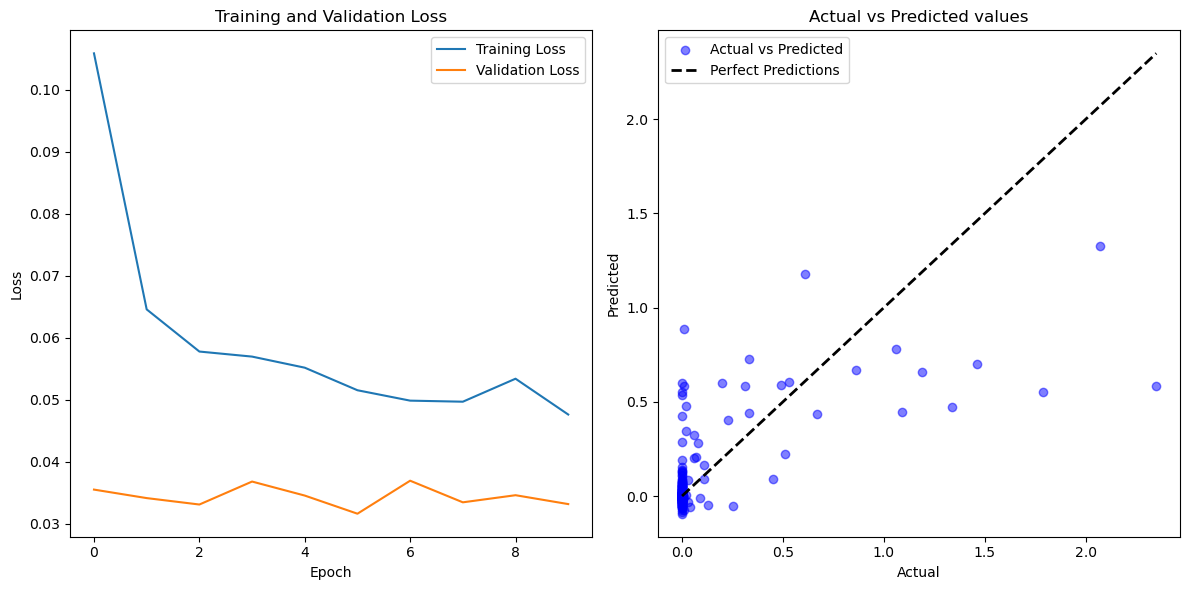

Correlation Coefficient: 0.6853142152417747

 Root Mean Squared Error (RMSE): 0.24011890257829807 


 Correlation Coefficient: 0.6853142152417747 



In [ ]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, num_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(input_train_reshaped, output_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss = model.evaluate(input_test_reshaped, output_test)
print('\n',f'Test Loss: {loss}','\n')

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting actual vs predicted values
plt.subplot(1, 2, 2)
predictions = model.predict(input_test_reshaped)
plt.scatter(output_test, predictions, alpha=0.5, color='blue', label='Actual vs Predicted')
plt.plot([output_test.min(), output_test.max()], [output_test.min(), output_test.max()], '--k', linewidth=2, label='Perfect Predictions')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate correlation coefficient
corr_coef, _ = pearsonr(output_test, predictions.flatten())
print(f'Correlation Coefficient: {corr_coef}')

# Calculate Mean Squared Error
mse = mean_squared_error(output_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('\n',f'Root Mean Squared Error (RMSE): {rmse}','\n')

# Calculate correlation coefficient
corr_coef, _ = pearsonr(output_test, predictions.flatten())
print('\n',f'Correlation Coefficient: {corr_coef}','\n')

The training MAE is:  0.12 

Scores RMSE:  [0.24048664 0.19893182 0.1864907  0.38669994 0.19862513 0.17615969
 0.45372575 0.16930159 0.19506135 0.17602164]
Standard deviation:  0.09413494712069778 

Mean RMSE is:  0.23815042537639922
Correlation Coefficient:  0.5795684283494371 



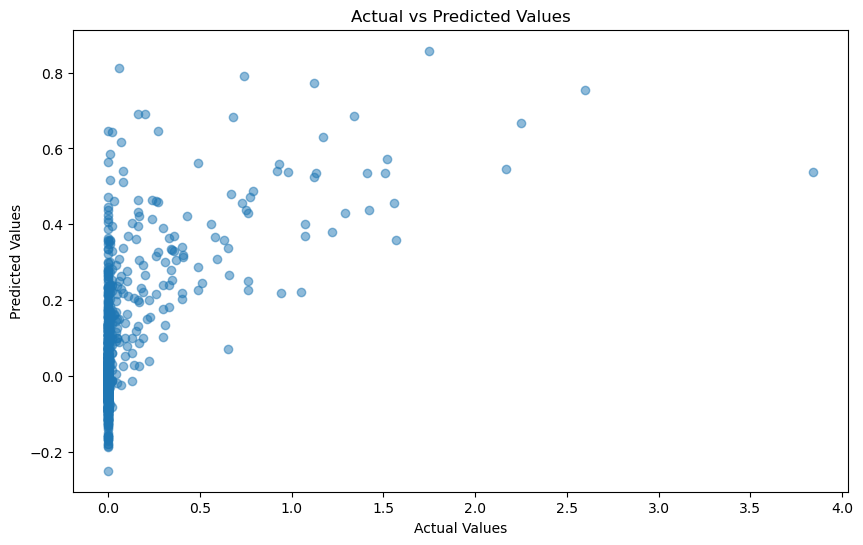

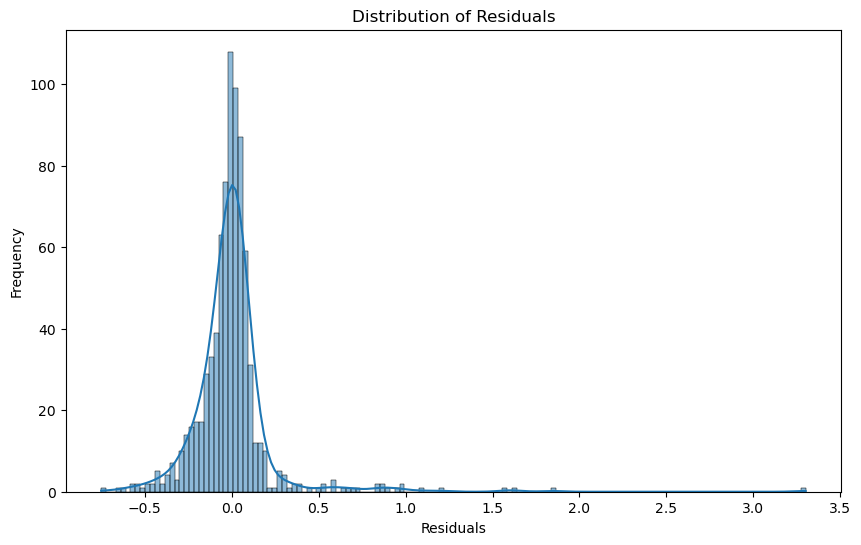

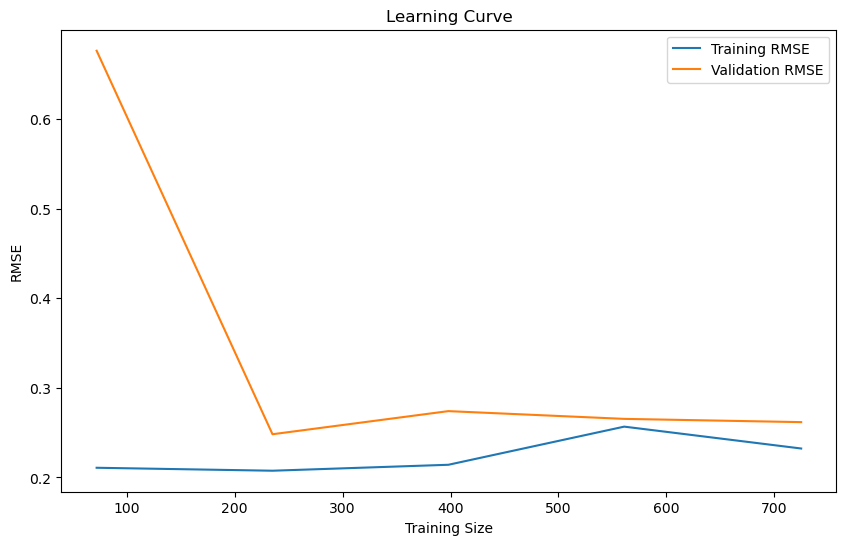

In [ ]:
# Create the multilayer perceptron regressor model.
# The neural network is trained using standardized data:
mlpr = MLPRegressor(hidden_layer_sizes = (16,), solver = 'lbfgs', max_iter = 10000)
mlpr.fit(input_train, output_train)

# Make predictions:
predictions_mlpr = mlpr.predict(input_train)

# Evaluate the model on the training set.
# The Mean Absolute Error:
mae_training = mean_absolute_error(output_train, predictions_mlpr)
print("The training MAE is: ", round(mae_training, 2), "\n")
# The Root Mean Squared Error:
scores = cross_val_score(mlpr, input_train, output_train, scoring = "neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
# Let's look at the results:
def display_scores(scores):
    print("Scores RMSE: ", scores)
    print("Standard deviation: ", scores.std(), "\n")
    print("Mean RMSE is: ", scores.mean())


display_scores(rmse_scores)

correlation_coefficient, _ = pearsonr(predictions_mlpr, output_train)
print("Correlation Coefficient: ", correlation_coefficient, "\n")


# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(output_train, predictions_mlpr, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plotting the distribution of residuals
residuals = output_train - predictions_mlpr
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(mlpr, input_train, output_train, cv=10, scoring='neg_mean_squared_error')
train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Training RMSE')
plt.plot(train_sizes, test_rmse, label='Validation RMSE')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.legend()
plt.show()


The training MAE is:  0.03 

Scores RMSE:  [0.24364111 0.18788625 0.21547073 0.33211583 0.25001411 0.16634333
 0.43660595 0.12225171 0.25320363 0.12159898]
Standard deviation:  0.09140632536381418 

Mean RMSE is:  0.23291316355809272
Correlation Coefficient:  0.9559345881569206 



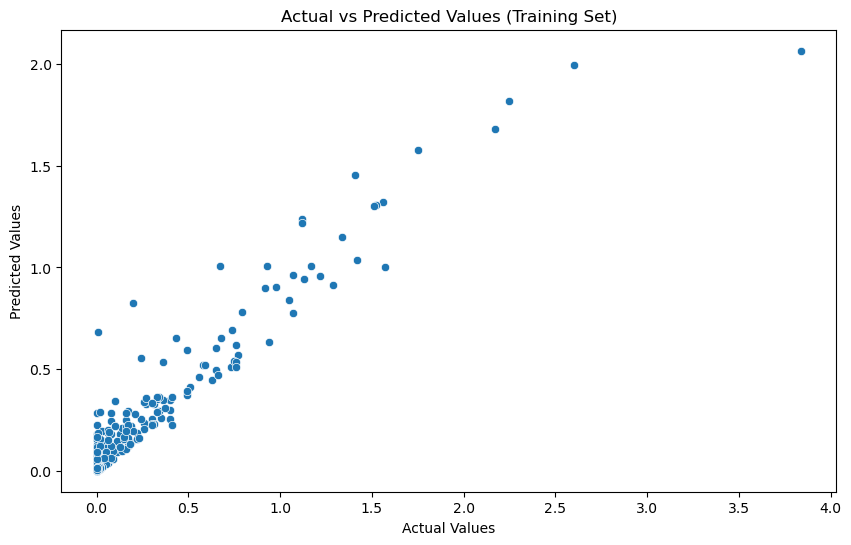

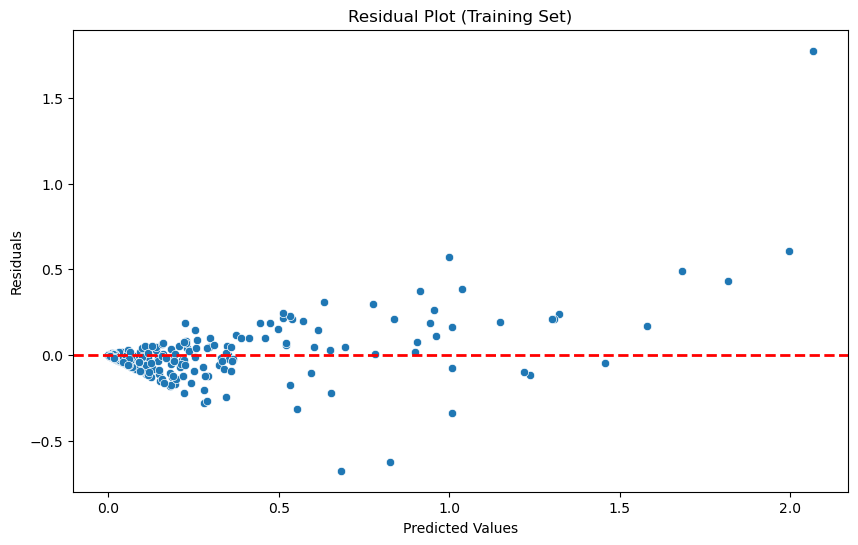

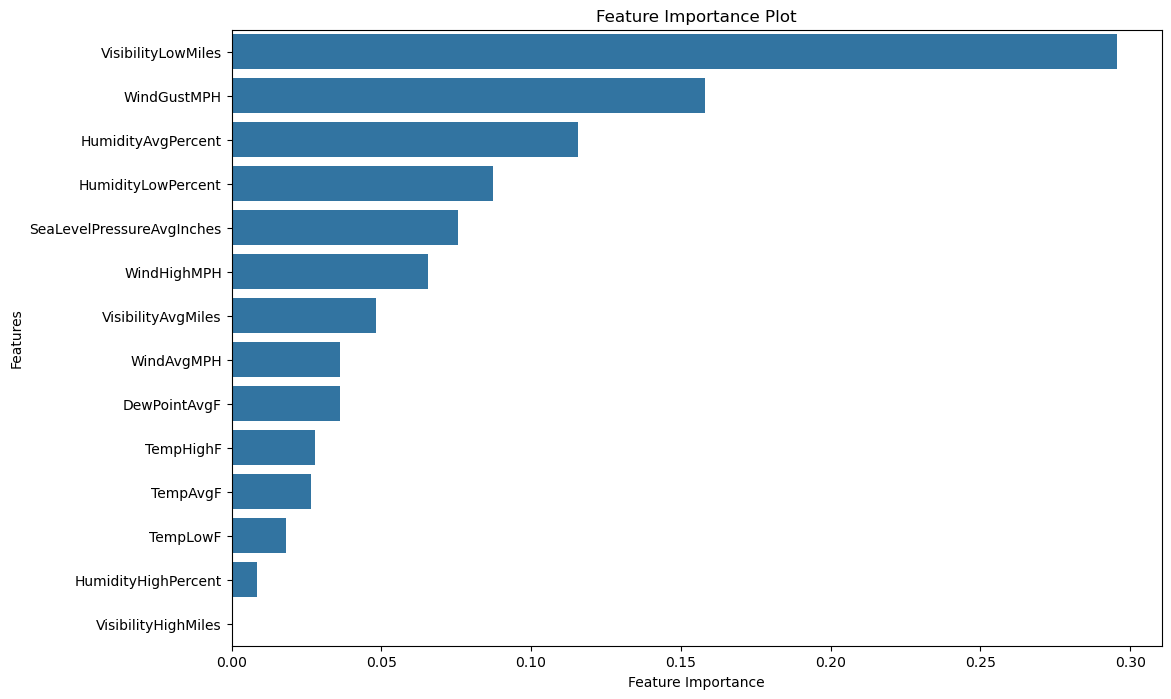

In [ ]:
# Make a Random Forest Regressor model and train it:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(input_train, output_train)

# Make predictions:
predictions_forest = forest_reg.predict(input_train)

# Evaluate the model on the training set.
# The Mean Absolute Error:
mae_training = mean_absolute_error(output_train, predictions_forest)
print("The training MAE is: ", round(mae_training, 2), "\n")
# The Root Mean Squared Error:
scores = cross_val_score(forest_reg, input_train, output_train, scoring = "neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
# Let's look at the results:
def display_scores(scores):
    print("Scores RMSE: ", scores)
    print("Standard deviation: ", scores.std(), "\n")
    print("Mean RMSE is: ", scores.mean())


display_scores(rmse_scores)

correlation_coefficient, _ = pearsonr(predictions_forest, output_train)
print("Correlation Coefficient: ", correlation_coefficient, "\n")


# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=output_train, y=predictions_forest)
plt.title('Actual vs Predicted Values (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual plot
residuals = output_train - predictions_forest
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_forest, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot (Training Set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Feature Importance Plot
feature_names = input_train.columns  # Replace with the actual method to get feature names
feature_importances = forest_reg.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
plt.title('Feature Importance Plot')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


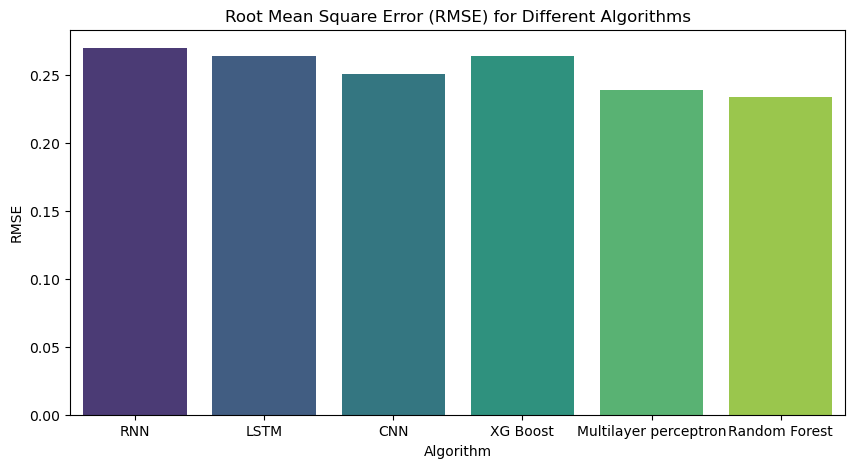

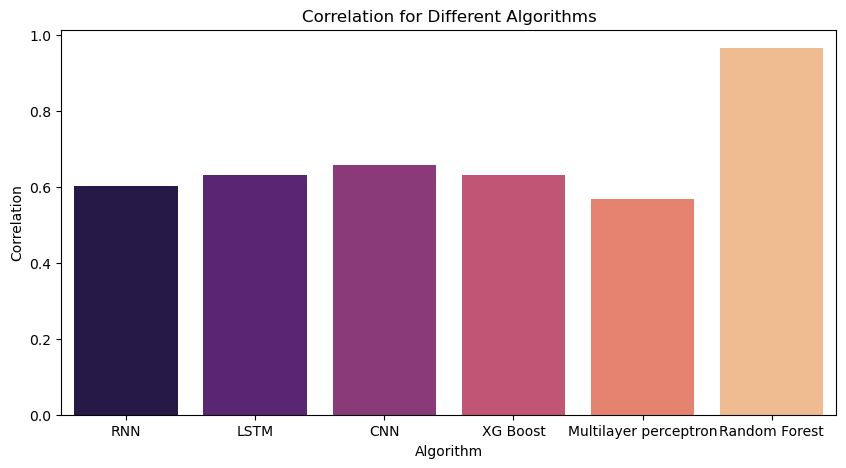

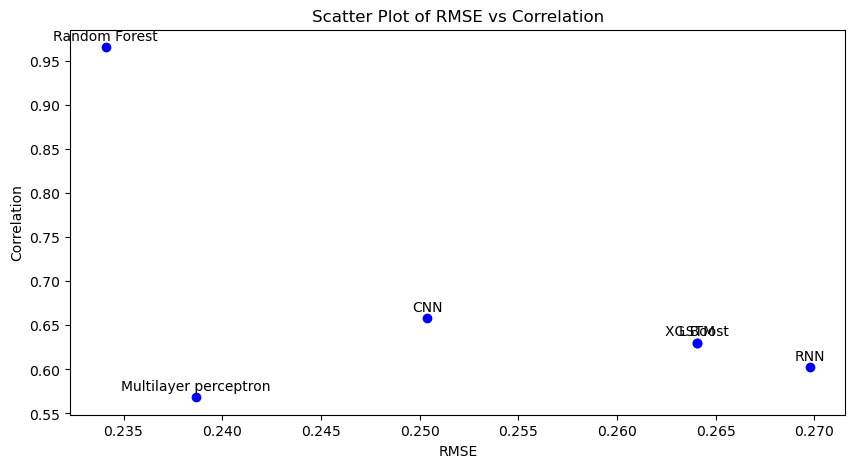

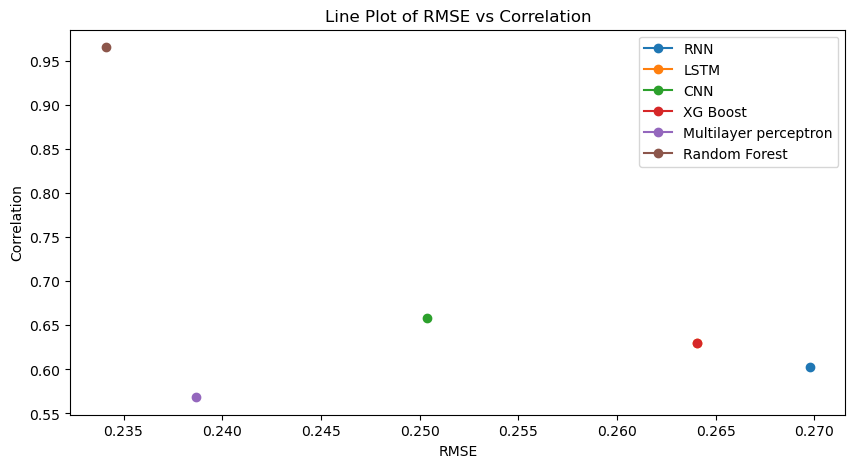

In [ ]:
# Data
data = {
    'Algorithm': ['RNN', 'LSTM', 'CNN', 'XG Boost', 'Multilayer perceptron', 'Random Forest'],
    'RMSE': [0.2698, 0.2640, 0.2504, 0.2640, 0.2387, 0.2341],
    'Correlation': [0.6028, 0.6304, 0.6580, 0.6304, 0.5684, 0.9657]
}

df = pd.DataFrame(data)

# Plotting RMSE
plt.figure(figsize=(10, 5))
sns.barplot(x='Algorithm', y='RMSE', data=df, palette='viridis')
plt.title('Root Mean Square Error (RMSE) for Different Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.show()

# Plotting Correlation
plt.figure(figsize=(10, 5))
sns.barplot(x='Algorithm', y='Correlation', data=df, palette='magma')
plt.title('Correlation for Different Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Correlation')
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(rmse_values, correlation_values, color='blue', marker='o')
plt.title('Scatter Plot of RMSE vs Correlation')
plt.xlabel('RMSE')
plt.ylabel('Correlation')
for i, label in enumerate(algorithm_names):
    plt.annotate(label, (rmse_values[i], correlation_values[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.show()

# Line Plot
plt.figure(figsize=(10, 5))
for i in range(len(algorithm_names)):
    plt.plot([rmse_values[i]], [correlation_values[i]], marker='o', label=algorithm_names[i])

plt.title('Line Plot of RMSE vs Correlation')
plt.xlabel('RMSE')
plt.ylabel('Correlation')
plt.legend()
plt.show()